# DigitRecognizer for a ML challenge - Training on Image Data
+ The goal of this notebook is to explore some models on Image Data to beat the Tabular Models

**Content:**
1. [Loading libraries](#1)
1. [Exporting images](#2)
    1. [Train](#3)
    1. [Test](#4)
1. [Fastai and Image data](#5)
    1. [accuracy=0.992, Resnet34, 128px, label_smoothing, Mixup, fit_one_cycle(10,1e-3,wd=0.1), aug_transforms(do_flip=False)](#6)
        1. [Error Analysis](#7)
    1. [accuracy=0.995, Resnet34, 256px, label_smoothing, Mixup, fit_one_cycle(50,1e-3,wd=0.1), aug_transforms(do_flip=False)](#8)
        1. [Error Analysis](#9)
    1. [accuracy=0.996, convnext_base_384_in22ft1k, 224px, label_smoothing, Mixup, fit_one_cycle(50,1e-3,wd=0.1), aug_transforms(do_flip=False)](#10)
        1. [Error Analysis](#11)
    1. [accuracy=0.994, vit_base_patch16_224, 224px, label_smoothing, Mixup, fit_one_cycle(10,1e-3,wd=0.1), aug_transforms(do_flip=False)](#12)
        1. [Error Analysis](#13)

<a id="1"></a> <br>
# Loading libraries
+ We use fastai, numpy, sklearn and matplotlib
+ Additionally, we will use the last version of fastai with timm library compatibity to try new SOTA vision models

In [ ]:
!pip install -Uqq fastai timm
!pip install --user torch==1.9.0 torchvision==0.10.0

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt

In [ ]:
from fastai.vision.all import *
from fastai.vision.widgets import *
from fastai.callback.fp16 import *
from fastai.vision import *
import fastai
import torch
from fastai.callback.all import SaveModelCallback
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import timm
import shutil

In [ ]:
print("Fastai version: ",fastai.__version__)

In [ ]:
print("GPU a utilizar: ",torch.cuda.get_device_name(0))

In [ ]:
torch.cuda.set_device(0)

In [ ]:
#To show and save the graphics in the notebook
%matplotlib inline
#To reload automatically all the modules after executing a cell
%reload_ext autoreload
%autoreload 2

<a id="2"></a> <br>
# Exporting images
+ From the train and test datasets provided we will generate all the images at their original size (28x28) to iterate with the vision models

<a id="3"></a> <br>
## Train

In [ ]:
path=Path('../input/digit-recognizer')

In [ ]:
df=pd.read_csv('../input/mnist-tabular-dataset/MNIST_tabular_dataset.csv')

In [ ]:
image_folder='./train'

In [ ]:
if not os.path.exists(image_folder):
    os.makedirs(image_folder)

In [ ]:
df

In [ ]:
df['image_name']='[]'
for index in range(len(df)):
    image=np.array(df.iloc[index,(df.columns!='label')&(df.columns!='set')&(df.columns!='image_name')],dtype='uint8').reshape(28,28)
    Image.fromarray(image).save(image_folder+'/'+f'Image_{index}.png')
    df.at[index,'image_name']=f'Image_{index}.png'

In [ ]:
df.to_csv('./MNIST_dataset_Image_Data_train.csv',index=False)

In [ ]:
shutil.make_archive('train_images', 'zip', './train')

+ Let's download the data created and csv for iterating later

<a id="4"></a> <br>
## Test

In [ ]:
path=Path('../input/digit-recognizer')
df_test=pd.read_csv(os.path.join(path, 'test.csv'))

In [ ]:
image_folder='./test'

In [ ]:
if not os.path.exists(image_folder):
    os.makedirs(image_folder)

In [ ]:
df_test

In [ ]:
df_test['image_name']='[]'
for index in range(len(df_test)):
    image=np.array(df_test.iloc[index,(df_test.columns!='image_name')],dtype='uint8').reshape(28,28)
    Image.fromarray(image).save(image_folder+'/'+f'Image_{index}.png')
    df_test.at[index,'image_name']=f'Image_{index}.png'

In [ ]:
df_test.to_csv('./MNIST_dataset_Image_Data_test.csv',index=False)

In [ ]:
shutil.make_archive('test_images', 'zip', './test')

<a id="5"></a> <br>
# Fastai and Image Data
+ We will try some different models
+ We fix the augmentations (by default, except the flipping), MixUP, weight decay and label smoothing

<a id="6"></a> <br>
## accuracy=0.992, Resnet34, 128px, label_smoothing, Mixup, fit_one_cycle(10,1e-3,wd=0.1), aug_transforms(do_flip=False)

In [ ]:
path=Path('../input/mnist-image-data-train/train_images')

In [ ]:
df=pd.read_csv('../input/mnist-image-data-train/MNIST_dataset_Image_Data_train.csv')

In [12]:
df

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,set,image_name
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,train,Image_0.png
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,train,Image_1.png
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,train,Image_2.png
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,train,Image_3.png
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,train,Image_4.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,val,Image_41995.png
41996,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,val,Image_41996.png
41997,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,val,Image_41997.png
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,val,Image_41998.png


In [ ]:
def get_x(r): return path/r['image_name']
def get_y(r): return r['label']

In [ ]:
def splitter(df):
    train = df.index[df['set']=='train'].tolist()
    valid = df.index[df['set']=='val'].tolist()
    return train,valid

In [ ]:
def gen_data(size,bs=64):
    datablock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                          splitter=splitter,
                          item_tfms=Resize(size),
                          get_x=get_x,
                          get_y=get_y,
                          batch_tfms=aug_transforms(do_flip=False))
    return datablock.dataloaders(df,batch_size=bs)

def create_learn(dls, mixup=False, label_smooth_eps=0.1, model_dir = 'models',model='resnet34',metrics=accuracy):
    if mixup==False:
        learn = vision_learner(dls, arch=model, metrics=metrics,model_dir=model_dir, 
                        loss_func=LabelSmoothingCrossEntropy(eps=label_smooth_eps))
    else:
        learn = vision_learner(dls, arch=model, metrics=metrics, model_dir=model_dir,
                        loss_func=LabelSmoothingCrossEntropy(eps=label_smooth_eps),
                        cbs=MixUp)
        print('mixup enabled')
    learn.path = path
    learn = learn.to_fp16()
    return learn

def report_metrics(learn, preds):
    y_true = preds[1].tolist()
    y_probs = preds[0].numpy()
    auc = roc_auc_score(y_true, y_probs, multi_class='ovo') # ovo because macro avg is used (ovo is insensitive to class imbalance)
    print(f'AUC: {auc}')
    y_pred = y_probs.argmax(axis=1)
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))

In [ ]:
data=gen_data(128,128)

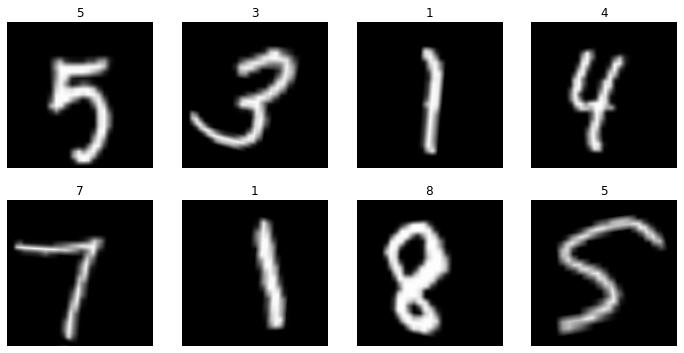

In [17]:
data.show_batch(nrows=2,ncols=4)

In [ ]:
!mkdir './models'

In [ ]:
learn=create_learn(data,model='resnet34',model_dir = '/kaggle/working/models',mixup=True,metrics=[accuracy,RocAuc()])

SuggestedLRs(valley=0.0012022644514217973)

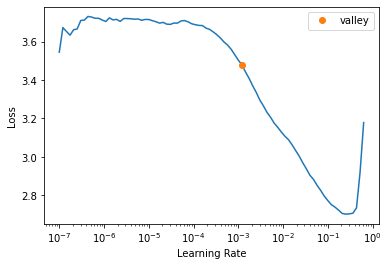

In [22]:
learn.lr_find()

In [23]:
learn.fit_one_cycle(10,1e-3,wd=0.1)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,1.900589,0.853837,0.918857,0.995081,00:30
1,1.323962,0.652469,0.973048,0.999188,00:30
2,1.075580,0.572957,0.984667,0.999765,00:29
3,1.000665,0.556947,0.989524,0.999776,00:27
4,0.973636,0.547102,0.991333,0.999866,00:30
5,0.944234,0.538922,0.992286,0.999906,00:30
6,0.932331,0.537664,0.992190,0.999861,00:30
7,0.929517,0.534919,0.992476,0.999863,00:27
8,0.921884,0.534213,0.992667,0.999908,00:30
9,0.924091,0.533785,0.992762,0.999885,00:30


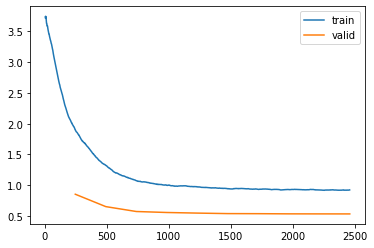

In [26]:
learn.recorder.plot_loss()

<a id="7"></a> <br>
### Error analysis

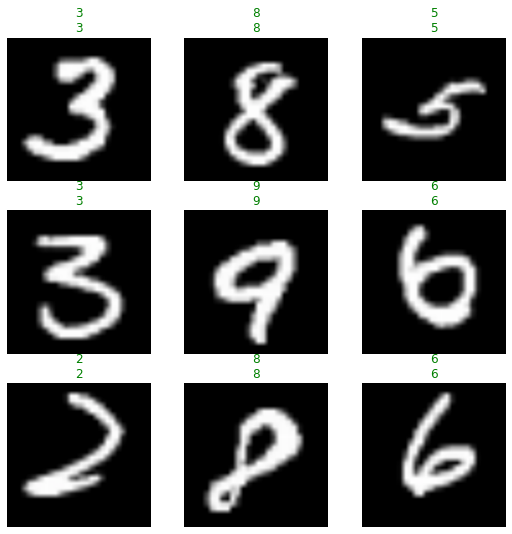

In [27]:
learn.show_results()

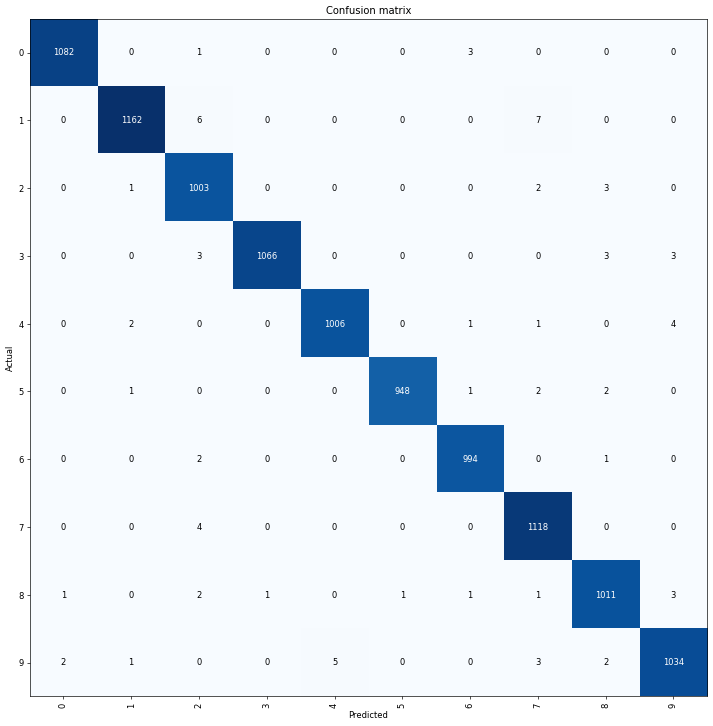

In [28]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
learn.recorder.plot_loss()interp.most_confused(min_val=5)

In [ ]:
preds = learn.get_preds()

In [51]:
report_metrics(learn, preds)

AUC: 0.9998848697948017
[[1082    0    1    0    0    0    3    0    0    0]
 [   0 1162    6    0    0    0    0    7    0    0]
 [   0    1 1003    0    0    0    0    2    3    0]
 [   0    0    3 1066    0    0    0    0    3    3]
 [   0    2    0    0 1006    0    1    1    0    4]
 [   0    1    0    0    0  948    1    2    2    0]
 [   0    0    2    0    0    0  994    0    1    0]
 [   0    0    4    0    0    0    0 1118    0    0]
 [   1    0    2    1    0    1    1    1 1011    3]
 [   2    1    0    0    5    0    0    3    2 1034]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1086
           1       1.00      0.99      0.99      1175
           2       0.98      0.99      0.99      1009
           3       1.00      0.99      1.00      1075
           4       1.00      0.99      0.99      1014
           5       1.00      0.99      1.00       954
           6       0.99      1.00      1.00       997
           7

In [52]:
interp.most_confused(min_val=5)

[(1, 7, 7), (1, 2, 6), (9, 4, 5)]

+ Improvements comparing to the tabular data. Let's try out bigger images

<a id="8"></a> <br>
## accuracy=0.995, Resnet34, 256px, label_smoothing, Mixup, fit_one_cycle(50,1e-3,wd=0.1), aug_transforms(do_flip=False)

In [ ]:
path=Path('../input/mnist-image-data-train/train_images')

In [ ]:
df=pd.read_csv('../input/mnist-image-data-train/MNIST_dataset_Image_Data_train.csv')

In [ ]:
def get_x(r): return path/r['image_name']
def get_y(r): return r['label']

In [ ]:
def splitter(df):
    train = df.index[df['set']=='train'].tolist()
    valid = df.index[df['set']=='val'].tolist()
    return train,valid

In [ ]:
def gen_data(size,bs=64):
    datablock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                          splitter=splitter,
                          item_tfms=Resize(size),
                          get_x=get_x,
                          get_y=get_y,
                          batch_tfms=aug_transforms(do_flip=False))
    return datablock.dataloaders(df,batch_size=bs)

def create_learn(dls, mixup=False, label_smooth_eps=0.1, model_dir = 'models',model='resnet34',metrics=accuracy):
    if mixup==False:
        learn = vision_learner(dls, arch=model, metrics=metrics,model_dir=model_dir, 
                        loss_func=LabelSmoothingCrossEntropy(eps=label_smooth_eps))
    else:
        learn = vision_learner(dls, arch=model, metrics=metrics, model_dir=model_dir,
                        loss_func=LabelSmoothingCrossEntropy(eps=label_smooth_eps),
                        cbs=MixUp)
        print('mixup enabled')
    learn.path = path
    learn = learn.to_fp16()
    return learn

def report_metrics(learn, preds):
    y_true = preds[1].tolist()
    y_probs = preds[0].numpy()
    auc = roc_auc_score(y_true, y_probs, multi_class='ovo') # ovo because macro avg is used (ovo is insensitive to class imbalance)
    print(f'AUC: {auc}')
    y_pred = y_probs.argmax(axis=1)
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))

In [ ]:
data=gen_data(256,128)

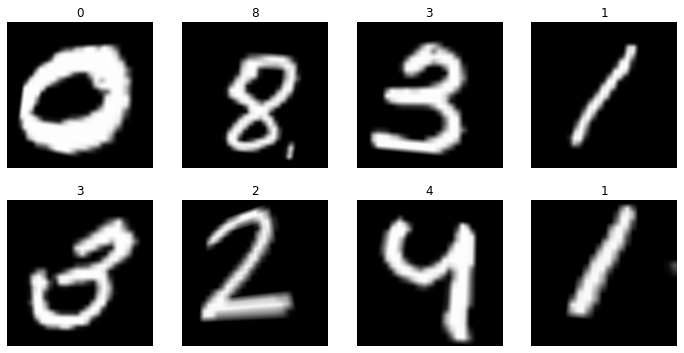

In [17]:
data.show_batch(nrows=2,ncols=4)

In [ ]:
!mkdir './models'

In [ ]:
learn=create_learn(data,model='resnet34',model_dir = '/kaggle/working/models',mixup=True,metrics=[accuracy,RocAuc()])

SuggestedLRs(valley=0.0012022644514217973)

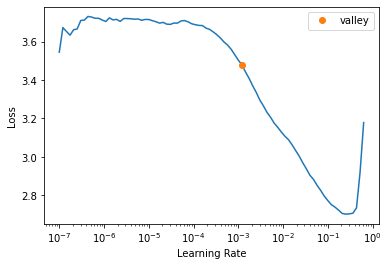

In [22]:
learn.lr_find()

In [19]:
learn.fit_one_cycle(10,1e-3,wd=0.1)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,1.607857,0.755976,0.952571,0.998179,01:12
1,1.115406,0.585642,0.984286,0.999740,01:26
2,0.989019,0.555050,0.989429,0.999881,01:12
3,0.947275,0.547852,0.992476,0.999926,01:26
4,0.936935,0.540994,0.992667,0.999939,01:11
5,0.921779,0.537387,0.993143,0.999961,01:26
6,0.910387,0.534237,0.993333,0.999962,01:11
7,0.904457,0.531846,0.993048,0.999963,01:27
8,0.889343,0.530912,0.993143,0.999962,01:12
9,0.896327,0.530607,0.993333,0.999961,01:26


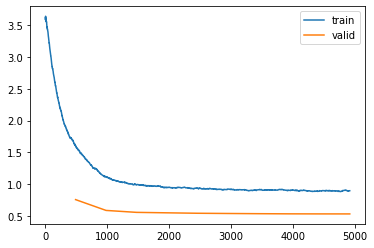

In [20]:
learn.recorder.plot_loss()

+ It looks like this model works a little bit better
+ Let's train longer

In [ ]:
learn.fit_one_cycle(50,1e-3,wd=0.1)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,1.986618,0.867389,0.889238,0.992216,00:44
1,1.632430,0.770122,0.947714,0.998043,00:45
2,1.396886,0.700751,0.971524,0.999284,00:45
3,1.202898,0.620847,0.984286,0.999696,00:45
4,1.076956,0.573345,0.988190,0.999855,00:45
5,0.997957,0.555504,0.990381,0.999912,00:45
6,0.967875,0.547927,0.990762,0.999906,00:45
7,0.958300,0.546648,0.991714,0.999910,00:46
8,0.928567,0.540838,0.992857,0.999955,00:45
9,0.915134,0.537866,0.992381,0.999953,00:45


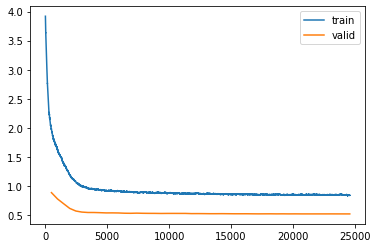

In [21]:
learn.recorder.plot_loss()

<a id="9"></a> <br>
### Error analysis

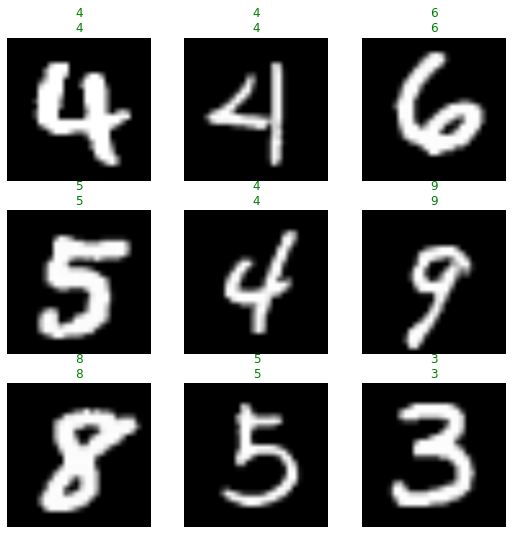

In [22]:
learn.show_results()

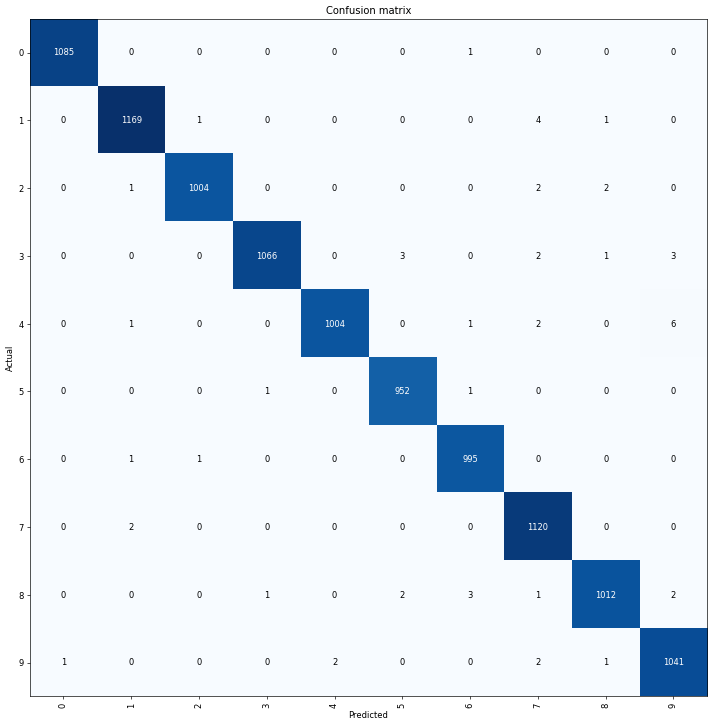

In [23]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [45]:
preds = learn.get_preds()

In [47]:
report_metrics(learn, preds)

AUC: 0.9999553768763625
[[1085    0    0    0    0    0    1    0    0    0]
 [   0 1169    1    0    0    0    0    4    1    0]
 [   0    1 1004    0    0    0    0    2    2    0]
 [   0    0    0 1066    0    3    0    2    1    3]
 [   0    1    0    0 1004    0    1    2    0    6]
 [   0    0    0    1    0  952    1    0    0    0]
 [   0    1    1    0    0    0  995    0    0    0]
 [   0    2    0    0    0    0    0 1120    0    0]
 [   0    0    0    1    0    2    3    1 1012    2]
 [   1    0    0    0    2    0    0    2    1 1041]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1086
           1       1.00      0.99      1.00      1175
           2       1.00      1.00      1.00      1009
           3       1.00      0.99      0.99      1075
           4       1.00      0.99      0.99      1014
           5       0.99      1.00      1.00       954
           6       0.99      1.00      1.00       997
           7

In [26]:
interp.most_confused(min_val=5)

[(4, 9, 6)]

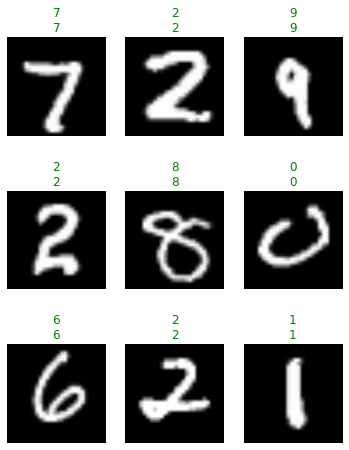

In [27]:
learn.show_results(ds_idx=1, nrows=3, figsize=(6,8))

+ Let's check out the errors

In [ ]:
preds, test_labels = learn.get_preds()

In [ ]:
final_preds = preds.numpy()
final_preds = np.argmax(final_preds, axis=1)

In [ ]:
def return_index_of_errors(test_labels,final_preds):
    return np.where(np.not_equal(final_preds,np.array(test_labels).reshape(len(np.array(test_labels)))))[0]

In [ ]:
indexes_to_check=return_index_of_errors(test_labels,final_preds)

In [ ]:
df_val=learn.dls.valid.items
df_val=df_val.reset_index()
df_val=df_val.drop(['index'],axis=1)

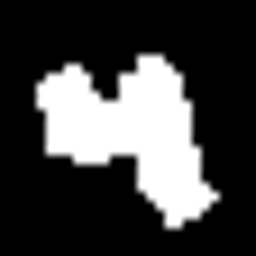

Label: 4
Prediction: 7


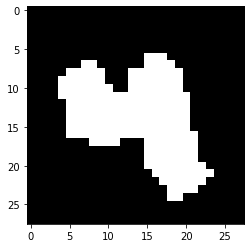

In [33]:
sample_index=df_val.iloc[np.random.choice(indexes_to_check)].name
image=np.array(df_val.iloc[sample_index,(df_val.columns!='label')&(df_val.columns!='set')&(df_val.columns!='image_name')],dtype='uint8').reshape(28,28)
plt.imshow(image,cmap='gray')
Image.open(path/df_val.iloc[sample_index].image_name).resize((256,256)).show()
print(f'Label: {df_val.iloc[sample_index].label}')
print(f'Prediction: {final_preds[sample_index]}')

In [ ]:
def show_errors(df_val,indexes_to_check):
    for index in indexes_to_check:
        sample_index=df_val.iloc[index].name
        Image.open(path/df_val.iloc[sample_index].image_name).resize((256,256)).show()
        print(f'Label: {df_val.iloc[sample_index].label}')
        print(f'Prediction: {final_preds[sample_index]}')
        plt.show()

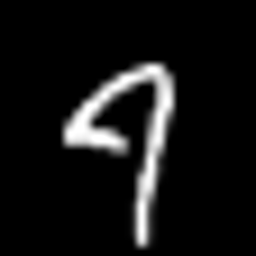

Label: 4
Prediction: 9


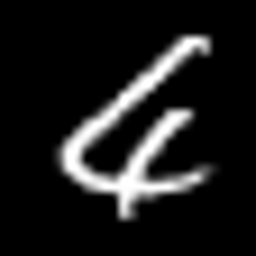

Label: 4
Prediction: 6


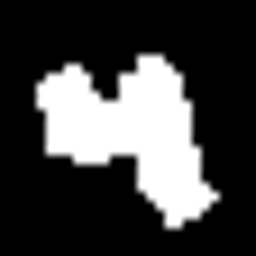

Label: 4
Prediction: 7


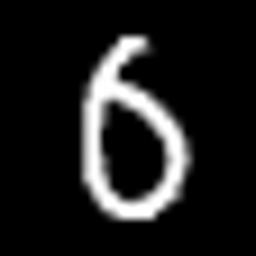

Label: 0
Prediction: 6


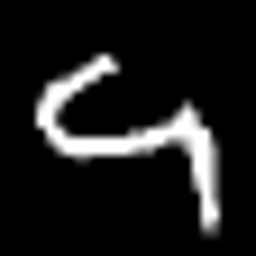

Label: 4
Prediction: 9


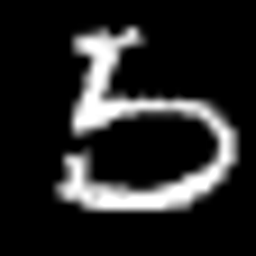

Label: 5
Prediction: 3


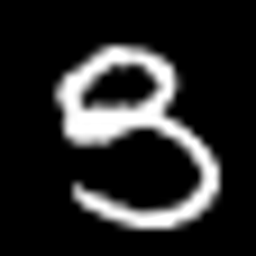

Label: 3
Prediction: 9


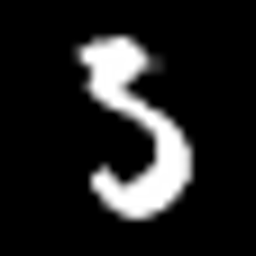

Label: 3
Prediction: 5


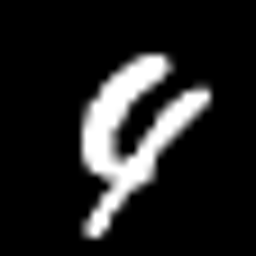

Label: 4
Prediction: 9


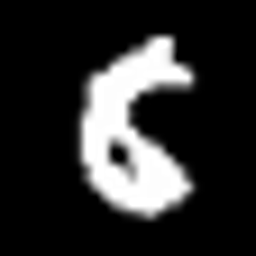

Label: 8
Prediction: 6


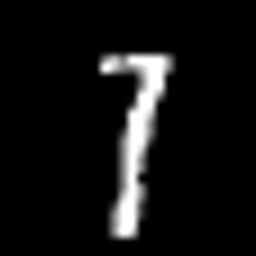

Label: 1
Prediction: 7


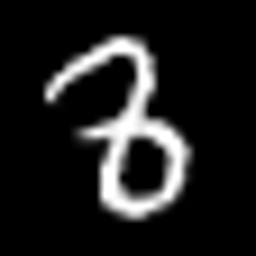

Label: 8
Prediction: 3


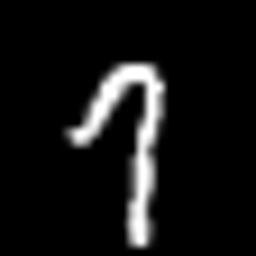

Label: 9
Prediction: 7


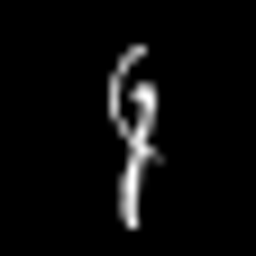

Label: 4
Prediction: 9


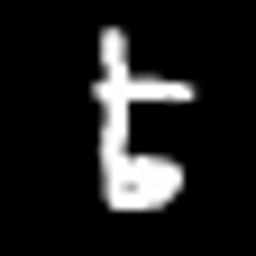

Label: 5
Prediction: 6


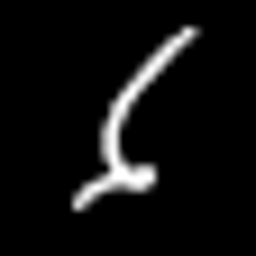

Label: 6
Prediction: 1


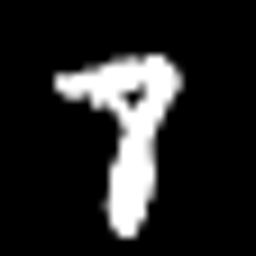

Label: 8
Prediction: 7


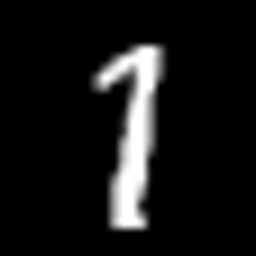

Label: 1
Prediction: 7


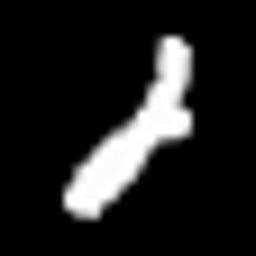

Label: 2
Prediction: 1


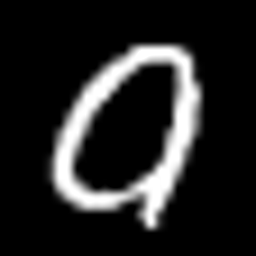

Label: 9
Prediction: 0


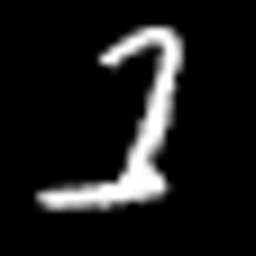

Label: 1
Prediction: 2


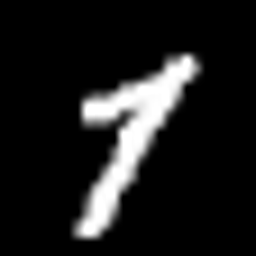

Label: 1
Prediction: 7


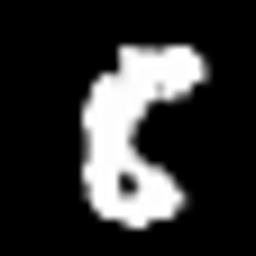

Label: 8
Prediction: 6


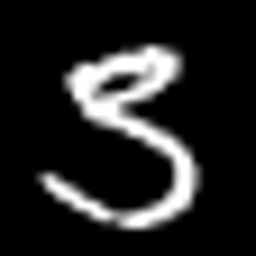

Label: 3
Prediction: 5


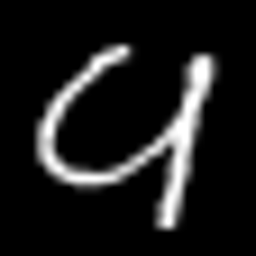

Label: 9
Prediction: 4


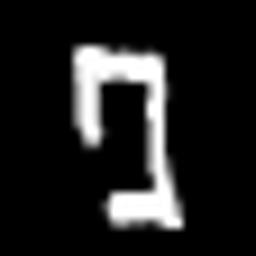

Label: 7
Prediction: 1


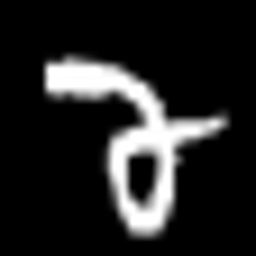

Label: 2
Prediction: 8


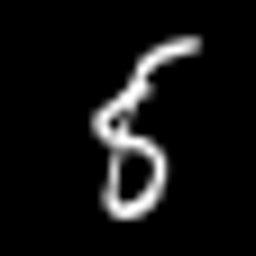

Label: 8
Prediction: 5


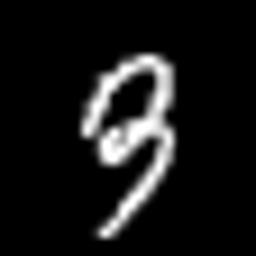

Label: 3
Prediction: 9


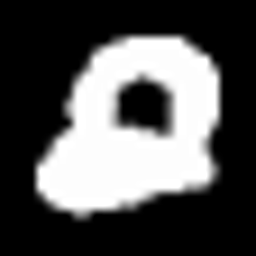

Label: 2
Prediction: 8


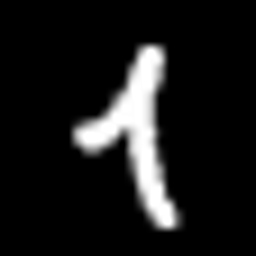

Label: 4
Prediction: 1


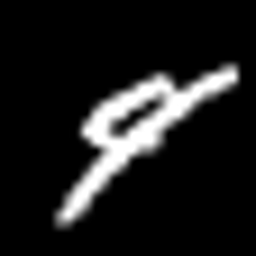

Label: 4
Prediction: 9


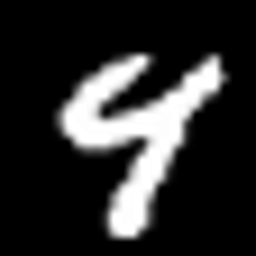

Label: 4
Prediction: 9


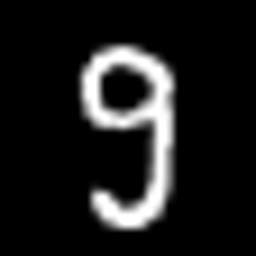

Label: 3
Prediction: 9


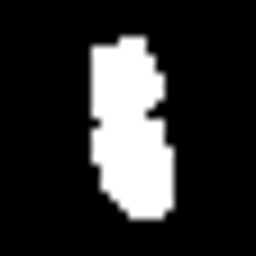

Label: 1
Prediction: 8


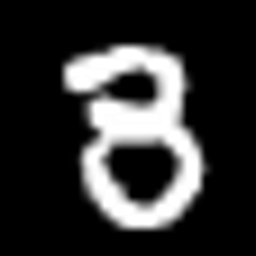

Label: 3
Prediction: 8


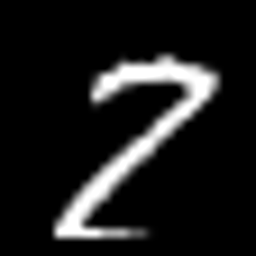

Label: 2
Prediction: 7


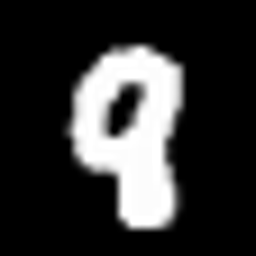

Label: 8
Prediction: 9


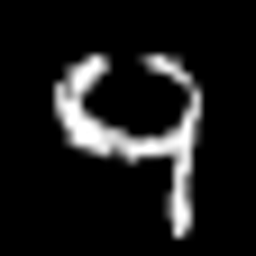

Label: 9
Prediction: 4


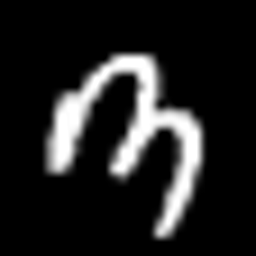

Label: 3
Prediction: 7


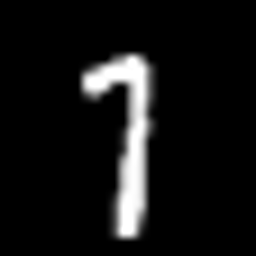

Label: 1
Prediction: 7


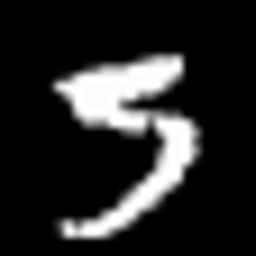

Label: 3
Prediction: 5


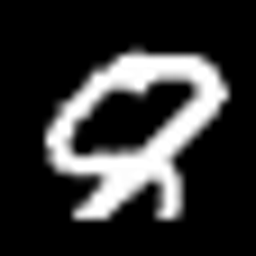

Label: 8
Prediction: 9


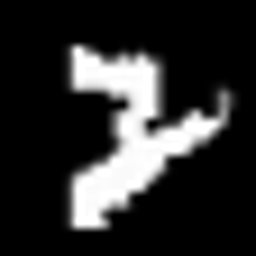

Label: 2
Prediction: 7


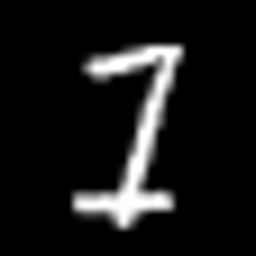

Label: 7
Prediction: 1


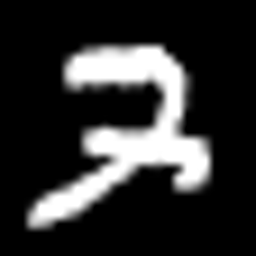

Label: 3
Prediction: 7


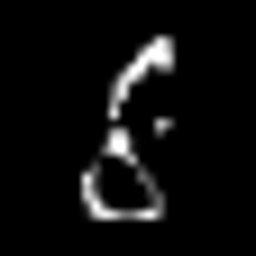

Label: 8
Prediction: 6


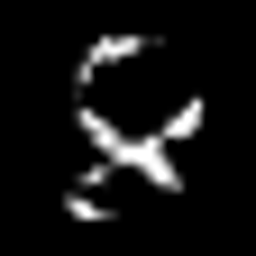

Label: 8
Prediction: 5


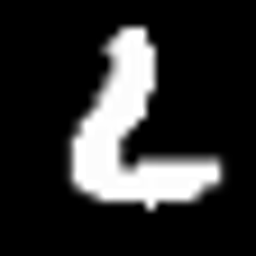

Label: 6
Prediction: 2


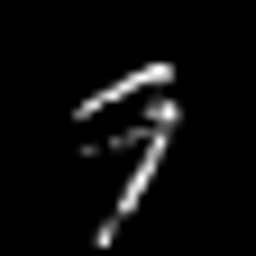

Label: 9
Prediction: 7


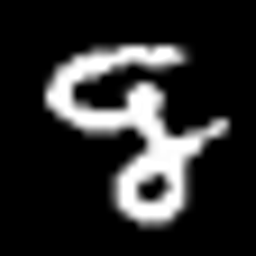

Label: 9
Prediction: 8


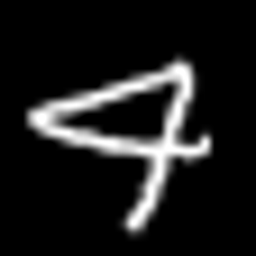

Label: 4
Prediction: 7


In [35]:
show_errors(df_val,indexes_to_check)

In [36]:
len(indexes_to_check)

52

+ Out of 52 mistakes, 25 are real mistakes, 27 rest of them are mislabelling or impossible to be sure
+ That would be a 99.76% accuracy instead of 99.5%
+ Let's export the model for the inference notebook

In [ ]:
learn.export('./resnet34_256_acc0995.pkl')

<a id="10"></a> <br>
## accuracy=0.996, convnext_base_384_in22ft1k, 224px, label_smoothing, Mixup, fit_one_cycle(50,1e-3,wd=0.1), aug_transforms(do_flip=False)

In [ ]:
path=Path('../input/mnist-image-data-train/train_images')

In [ ]:
df=pd.read_csv('../input/mnist-image-data-train/MNIST_dataset_Image_Data_train.csv')

In [ ]:
def get_x(r): return path/r['image_name']
def get_y(r): return r['label']

In [ ]:
def splitter(df):
    train = df.index[df['set']=='train'].tolist()
    valid = df.index[df['set']=='val'].tolist()
    return train,valid

In [ ]:
def gen_data(size,bs=64):
    datablock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                          splitter=splitter,
                          item_tfms=Resize(size),
                          get_x=get_x,
                          get_y=get_y,
                          batch_tfms=aug_transforms(do_flip=False))
    return datablock.dataloaders(df,batch_size=bs)

def create_learn(dls, mixup=False, label_smooth_eps=0.1, model_dir = 'models',model='resnet34',metrics=accuracy):
    if mixup==False:
        learn = vision_learner(dls, arch=model, metrics=metrics,model_dir=model_dir, 
                        loss_func=LabelSmoothingCrossEntropy(eps=label_smooth_eps))
    else:
        learn = vision_learner(dls, arch=model, metrics=metrics, model_dir=model_dir,
                        loss_func=LabelSmoothingCrossEntropy(eps=label_smooth_eps),
                        cbs=MixUp)
        print('mixup enabled')
    learn.path = path
    learn = learn.to_fp16()
    return learn

def report_metrics(learn, preds):
    y_true = preds[1].tolist()
    y_probs = preds[0].numpy()
    auc = roc_auc_score(y_true, y_probs, multi_class='ovo') # ovo because macro avg is used (ovo is insensitive to class imbalance)
    print(f'AUC: {auc}')
    y_pred = y_probs.argmax(axis=1)
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))

In [ ]:
data=gen_data(224,64)

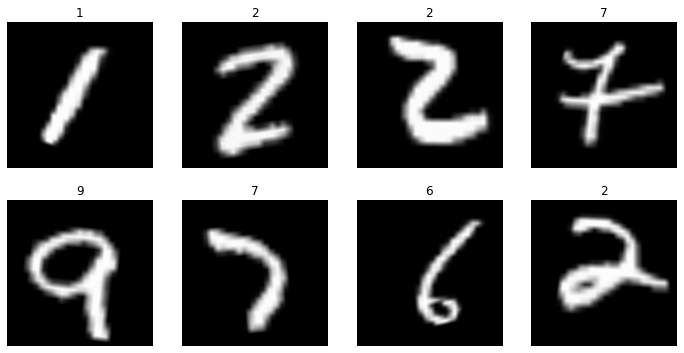

In [16]:
data.show_batch(nrows=2,ncols=4)

In [ ]:
!mkdir './models'

In [ ]:
learn=create_learn(data,model='convnext_base_384_in22ft1k',model_dir = '/kaggle/working/models',mixup=True,metrics=[accuracy,RocAuc()])

SuggestedLRs(valley=0.0010000000474974513)

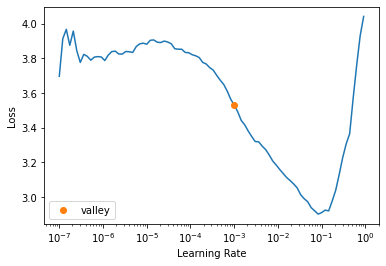

In [19]:
learn.lr_find()

In [18]:
learn.fit_one_cycle(10,1e-3,wd=0.1)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,1.500866,0.693669,0.964952,0.998906,03:45
1,1.093553,0.577539,0.987143,0.999795,03:40
2,0.968037,0.551916,0.992381,0.999912,03:42
3,0.938114,0.541603,0.992381,0.999951,03:40
4,0.917563,0.538260,0.993524,0.999953,03:42
5,0.899400,0.530696,0.994286,0.999947,03:34
6,0.887001,0.528149,0.994667,0.999939,02:22
7,0.875800,0.526832,0.994952,0.999935,02:07
8,0.874434,0.524955,0.995238,0.999933,02:08
9,0.876324,0.524758,0.995048,0.999929,02:11


+ Little bit better than any of the models trained before
+ Let's train longer then

In [19]:
learn.fit_one_cycle(50,1e-3,wd=0.1)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,1.760969,0.802111,0.928000,0.996469,02:08
1,1.491946,0.696230,0.968190,0.999054,02:07
2,1.299036,0.637380,0.979619,0.999572,02:07
3,1.150629,0.603974,0.987619,0.999842,02:07
4,1.035676,0.566811,0.991143,0.999882,02:07
5,0.980135,0.549490,0.992095,0.999929,02:07
6,0.943188,0.543369,0.993810,0.999938,02:07
7,0.936678,0.538252,0.994190,0.999967,02:07
8,0.908783,0.538107,0.994286,0.999954,02:07
9,0.907399,0.536947,0.993619,0.999926,02:07


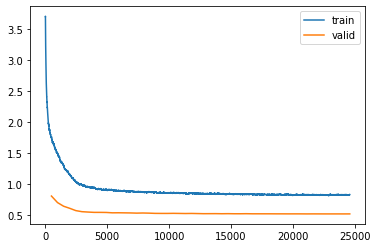

In [20]:
learn.recorder.plot_loss()

<a id="11"></a> <br>
### Error analysis

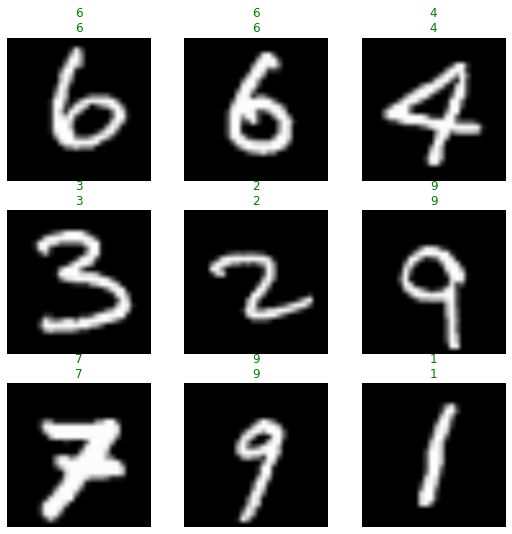

In [21]:
learn.show_results()

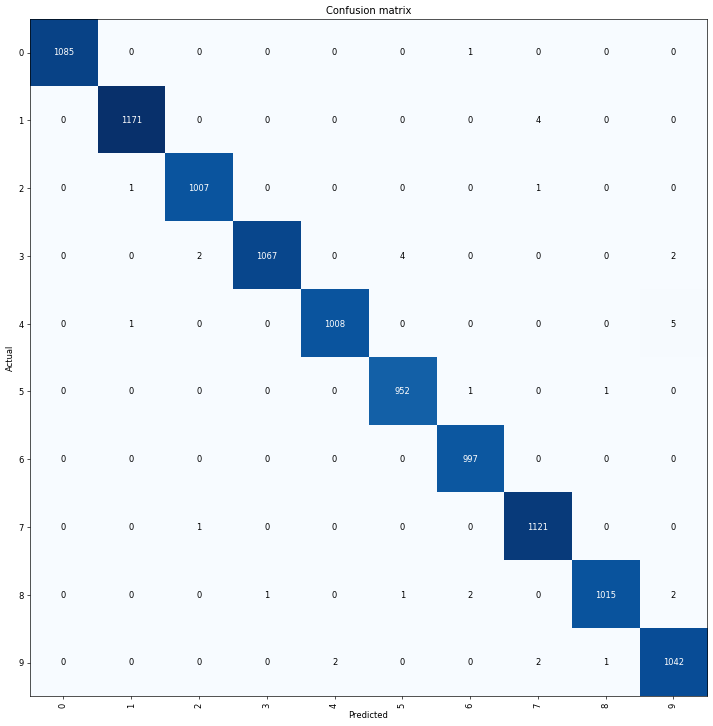

In [22]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [23]:
interp.most_confused(min_val=5)

[(4, 9, 5)]

In [ ]:
preds = learn.get_preds()

In [25]:
report_metrics(learn, preds)

AUC: 0.9999606948325626
[[1085    0    0    0    0    0    1    0    0    0]
 [   0 1171    0    0    0    0    0    4    0    0]
 [   0    1 1007    0    0    0    0    1    0    0]
 [   0    0    2 1067    0    4    0    0    0    2]
 [   0    1    0    0 1008    0    0    0    0    5]
 [   0    0    0    0    0  952    1    0    1    0]
 [   0    0    0    0    0    0  997    0    0    0]
 [   0    0    1    0    0    0    0 1121    0    0]
 [   0    0    0    1    0    1    2    0 1015    2]
 [   0    0    0    0    2    0    0    2    1 1042]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1086
           1       1.00      1.00      1.00      1175
           2       1.00      1.00      1.00      1009
           3       1.00      0.99      1.00      1075
           4       1.00      0.99      1.00      1014
           5       0.99      1.00      1.00       954
           6       1.00      1.00      1.00       997
           7

+ Let's check out the errors

In [ ]:
preds, test_labels = learn.get_preds()

In [ ]:
final_preds = preds.numpy()
final_preds = np.argmax(final_preds, axis=1)

In [ ]:
def return_index_of_errors(test_labels,final_preds):
    return np.where(np.not_equal(final_preds,np.array(test_labels).reshape(len(np.array(test_labels)))))[0]

In [ ]:
indexes_to_check=return_index_of_errors(test_labels,final_preds)

In [ ]:
df_val=learn.dls.valid.items
df_val=df_val.reset_index()
df_val=df_val.drop(['index'],axis=1)

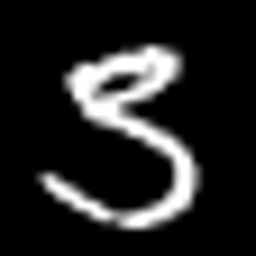

Label: 3
Prediction: 5


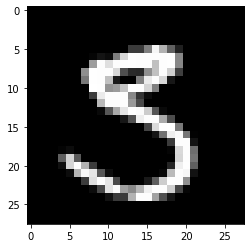

In [32]:
sample_index=df_val.iloc[np.random.choice(indexes_to_check)].name
image=np.array(df_val.iloc[sample_index,(df_val.columns!='label')&(df_val.columns!='set')&(df_val.columns!='image_name')],dtype='uint8').reshape(28,28)
plt.imshow(image,cmap='gray')
Image.open(path/df_val.iloc[sample_index].image_name).resize((256,256)).show()
print(f'Label: {df_val.iloc[sample_index].label}')
print(f'Prediction: {final_preds[sample_index]}')

In [ ]:
def show_errors(df_val,indexes_to_check):
    for index in indexes_to_check:
        sample_index=df_val.iloc[index].name
        Image.open(path/df_val.iloc[sample_index].image_name).resize((256,256)).show()
        print(f'Label: {df_val.iloc[sample_index].label}')
        print(f'Prediction: {final_preds[sample_index]}')
        plt.show()

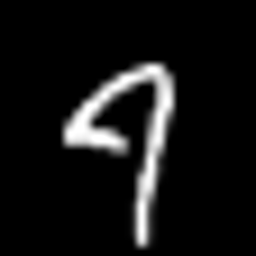

Label: 4
Prediction: 9


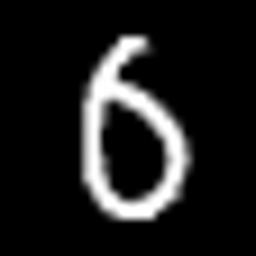

Label: 0
Prediction: 6


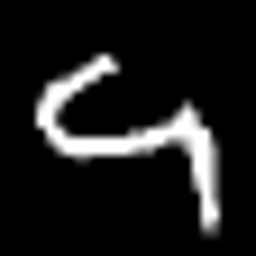

Label: 4
Prediction: 9


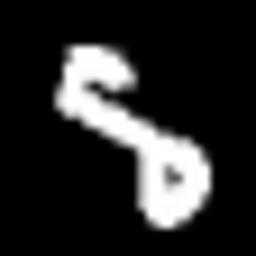

Label: 5
Prediction: 8


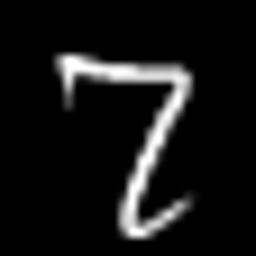

Label: 7
Prediction: 2


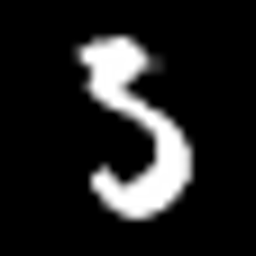

Label: 3
Prediction: 5


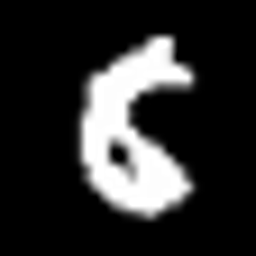

Label: 8
Prediction: 6


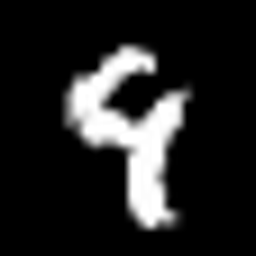

Label: 9
Prediction: 4


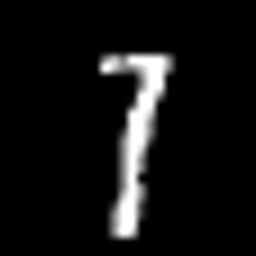

Label: 1
Prediction: 7


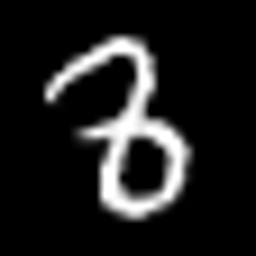

Label: 8
Prediction: 3


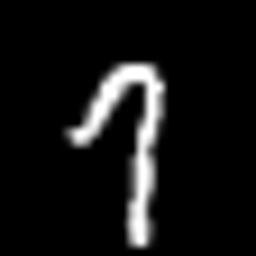

Label: 9
Prediction: 7


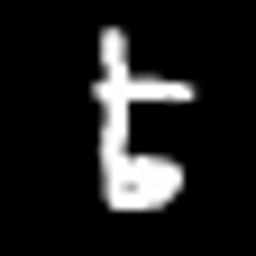

Label: 5
Prediction: 6


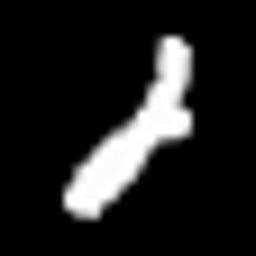

Label: 2
Prediction: 1


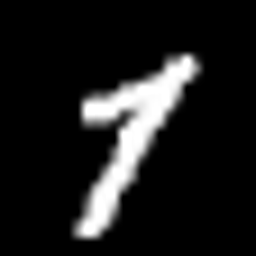

Label: 1
Prediction: 7


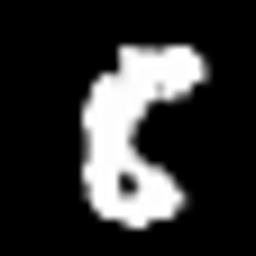

Label: 8
Prediction: 6


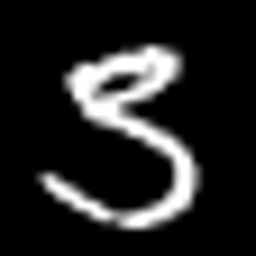

Label: 3
Prediction: 5


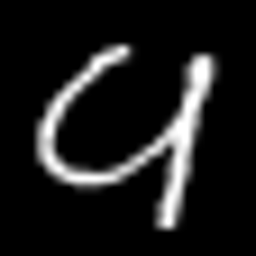

Label: 9
Prediction: 4


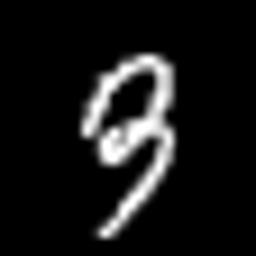

Label: 3
Prediction: 9


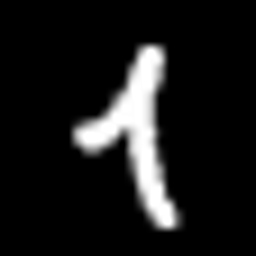

Label: 4
Prediction: 1


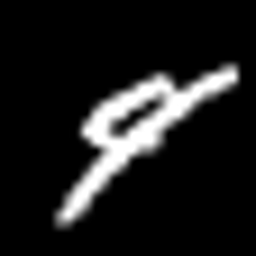

Label: 4
Prediction: 9


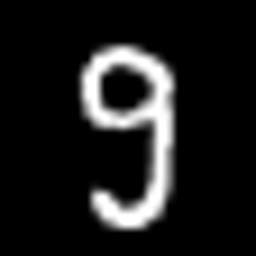

Label: 3
Prediction: 9


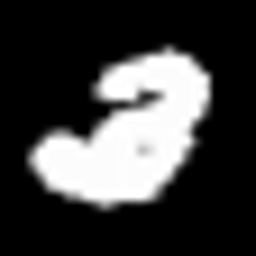

Label: 3
Prediction: 2


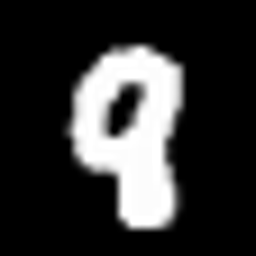

Label: 8
Prediction: 9


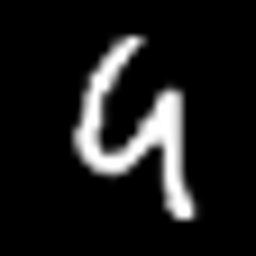

Label: 4
Prediction: 9


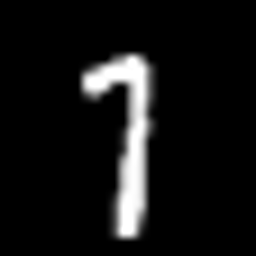

Label: 1
Prediction: 7


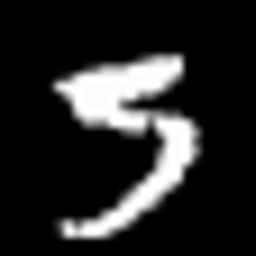

Label: 3
Prediction: 5


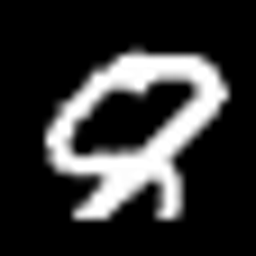

Label: 8
Prediction: 9


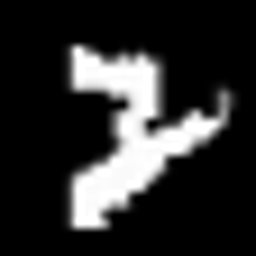

Label: 2
Prediction: 7


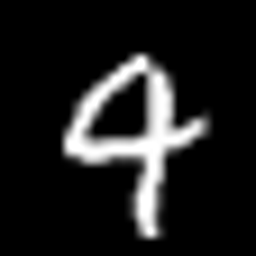

Label: 4
Prediction: 9


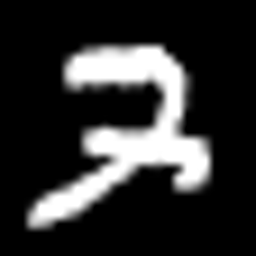

Label: 3
Prediction: 2


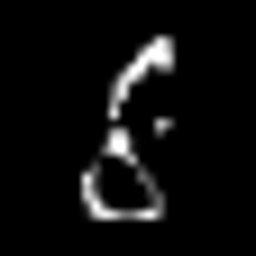

Label: 8
Prediction: 5


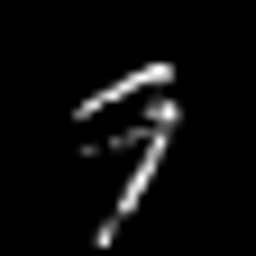

Label: 9
Prediction: 7


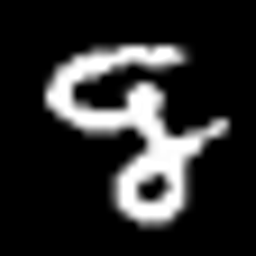

Label: 9
Prediction: 8


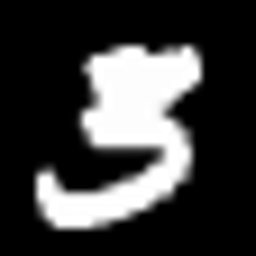

Label: 3
Prediction: 5


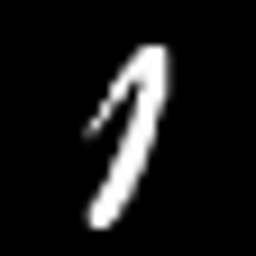

Label: 1
Prediction: 7


In [34]:
show_errors(df_val,indexes_to_check)

In [35]:
len(indexes_to_check)

35

+ Out of 35 mistakes, 9 are real mistakes, 26 rest of them are mislabelling or impossible to be sure
+ That would be a 99.9% accuracy instead of 99.6%
+ Let's export the model for inference time

In [ ]:
learn.export('./convnext_224_acc0997.pkl')

<a id="12"></a> <br>
## accuracy=0.994, vit_base_patch16_224, 224px, label_smoothing, Mixup, fit_one_cycle(10,1e-3,wd=0.1), aug_transforms(do_flip=False)

In [ ]:
path=Path('../input/mnist-image-data-train/train_images')

In [ ]:
df=pd.read_csv('../input/mnist-image-data-train/MNIST_dataset_Image_Data_train.csv')

In [ ]:
def get_x(r): return path/r['image_name']
def get_y(r): return r['label']

In [ ]:
def splitter(df):
    train = df.index[df['set']=='train'].tolist()
    valid = df.index[df['set']=='val'].tolist()
    return train,valid

In [ ]:
def gen_data(size,bs=64):
    datablock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                          splitter=splitter,
                          item_tfms=Resize(size),
                          get_x=get_x,
                          get_y=get_y,
                          batch_tfms=aug_transforms(do_flip=False))
    return datablock.dataloaders(df,batch_size=bs)

def create_learn(dls, mixup=False, label_smooth_eps=0.1, model_dir = 'models',model='resnet34',metrics=accuracy):
    if mixup==False:
        learn = vision_learner(dls, arch=model, metrics=metrics,model_dir=model_dir, 
                        loss_func=LabelSmoothingCrossEntropy(eps=label_smooth_eps))
    else:
        learn = vision_learner(dls, arch=model, metrics=metrics, model_dir=model_dir,
                        loss_func=LabelSmoothingCrossEntropy(eps=label_smooth_eps),
                        cbs=MixUp)
        print('mixup enabled')
    learn.path = path
    learn = learn.to_fp16()
    return learn

def report_metrics(learn, preds):
    y_true = preds[1].tolist()
    y_probs = preds[0].numpy()
    auc = roc_auc_score(y_true, y_probs, multi_class='ovo') # ovo because macro avg is used (ovo is insensitive to class imbalance)
    print(f'AUC: {auc}')
    y_pred = y_probs.argmax(axis=1)
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))

In [ ]:
data=gen_data(224,128)

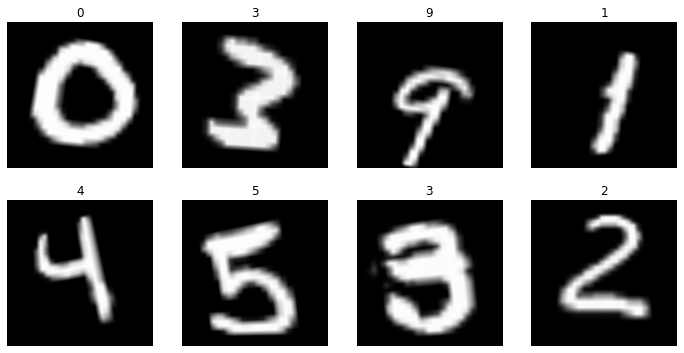

In [15]:
data.show_batch(nrows=2,ncols=4)

In [ ]:
!mkdir './models'

In [ ]:
learn=create_learn(data,model='vit_base_patch16_224',model_dir = '/kaggle/working/models',mixup=True,metrics=[accuracy,RocAuc()])

SuggestedLRs(valley=0.005248074419796467)

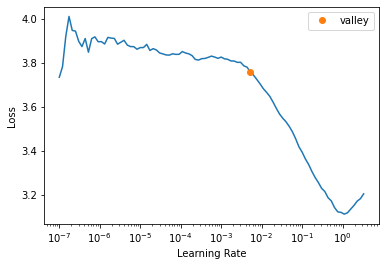

In [22]:
learn.lr_find()

In [17]:
learn.fit_one_cycle(10,1e-3,wd=0.1)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,1.316216,0.169131,0.951143,0.998188,01:31
1,0.849378,0.065484,0.981714,0.999750,01:32
2,0.687218,0.046177,0.988762,0.999894,01:31
3,0.617276,0.037066,0.992000,0.999936,01:31
4,0.574753,0.033343,0.992857,0.999939,01:31
5,0.549499,0.030258,0.993905,0.999955,01:31
6,0.525799,0.029732,0.993429,0.999949,01:31
7,0.513120,0.028312,0.994095,0.999957,01:31
8,0.521403,0.027459,0.994571,0.999957,01:31
9,0.522912,0.027788,0.994476,0.999956,01:32


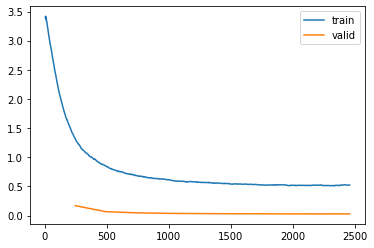

In [18]:
learn.recorder.plot_loss()

+ Not improving the best result

<a id="13"></a> <br>
### Error analysis

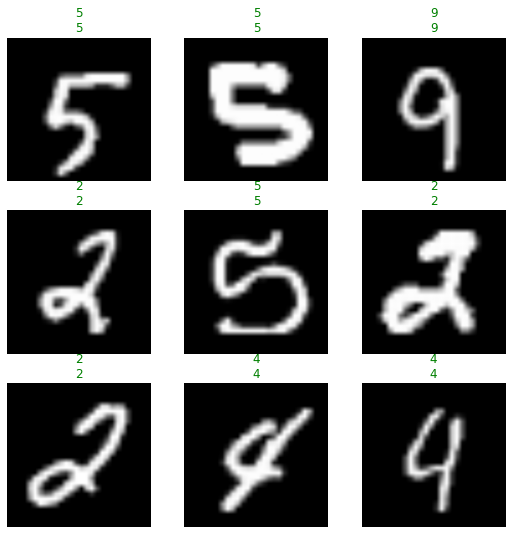

In [19]:
learn.show_results()

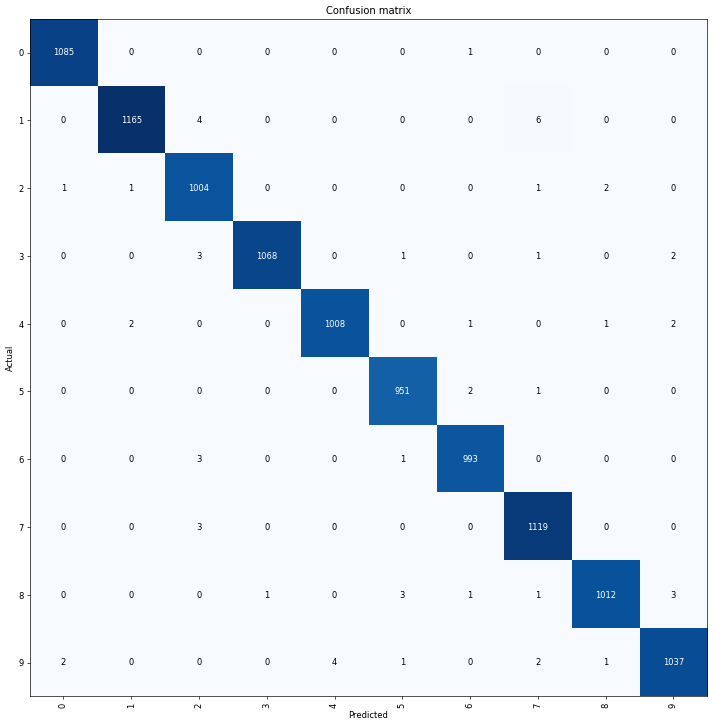

In [20]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [21]:
interp.most_confused(min_val=5)

[(1, 7, 6)]

In [ ]:
preds = learn.get_preds()

In [23]:
report_metrics(learn, preds)

AUC: 0.9999556638294465
[[1085    0    0    0    0    0    1    0    0    0]
 [   0 1165    4    0    0    0    0    6    0    0]
 [   1    1 1004    0    0    0    0    1    2    0]
 [   0    0    3 1068    0    1    0    1    0    2]
 [   0    2    0    0 1008    0    1    0    1    2]
 [   0    0    0    0    0  951    2    1    0    0]
 [   0    0    3    0    0    1  993    0    0    0]
 [   0    0    3    0    0    0    0 1119    0    0]
 [   0    0    0    1    0    3    1    1 1012    3]
 [   2    0    0    0    4    1    0    2    1 1037]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1086
           1       1.00      0.99      0.99      1175
           2       0.99      1.00      0.99      1009
           3       1.00      0.99      1.00      1075
           4       1.00      0.99      1.00      1014
           5       0.99      1.00      1.00       954
           6       0.99      1.00      1.00       997
           7

+ Let's check out the errors

In [ ]:
preds, test_labels = learn.get_preds()

In [ ]:
final_preds = preds.numpy()
final_preds = np.argmax(final_preds, axis=1)

In [ ]:
def return_index_of_errors(test_labels,final_preds):
    return np.where(np.not_equal(final_preds,np.array(test_labels).reshape(len(np.array(test_labels)))))[0]

In [ ]:
indexes_to_check=return_index_of_errors(test_labels,final_preds)

In [ ]:
df_val=learn.dls.valid.items
df_val=df_val.reset_index()
df_val=df_val.drop(['index'],axis=1)

In [ ]:
sample_index=df_val.iloc[np.random.choice(indexes_to_check)].name
image=np.array(df_val.iloc[sample_index,(df_val.columns!='label')&(df_val.columns!='set')&(df_val.columns!='image_name')],dtype='uint8').reshape(28,28)
plt.imshow(image,cmap='gray')
Image.open(path/df_val.iloc[sample_index].image_name).resize((256,256)).show()
print(f'Label: {df_val.iloc[sample_index].label}')
print(f'Prediction: {final_preds[sample_index]}')

In [ ]:
def show_errors(df_val,indexes_to_check):
    for index in indexes_to_check:
        sample_index=df_val.iloc[index].name
        Image.open(path/df_val.iloc[sample_index].image_name).resize((256,256)).show()
        print(f'Label: {df_val.iloc[sample_index].label}')
        print(f'Prediction: {final_preds[sample_index]}')
        plt.show()

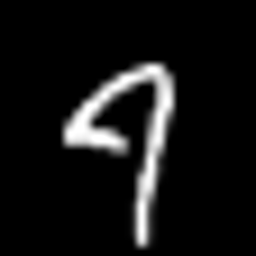

Label: 4
Prediction: 9


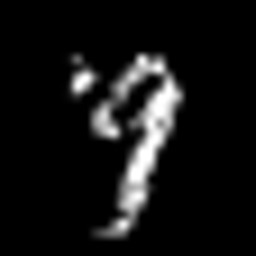

Label: 9
Prediction: 4


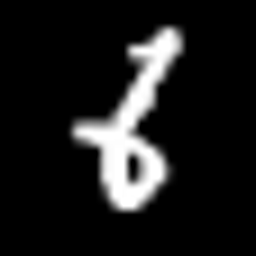

Label: 6
Prediction: 2


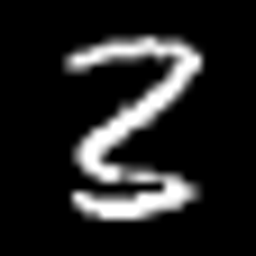

Label: 3
Prediction: 2


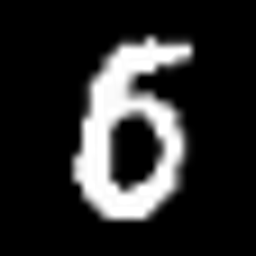

Label: 6
Prediction: 5


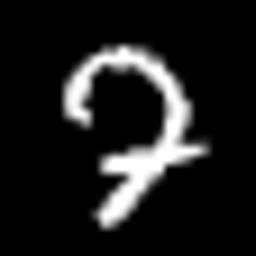

Label: 7
Prediction: 2


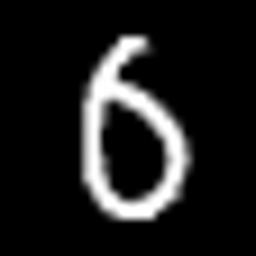

Label: 0
Prediction: 6


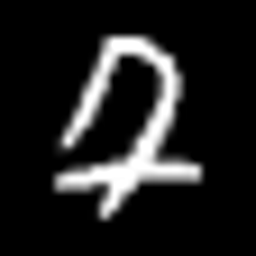

Label: 7
Prediction: 2


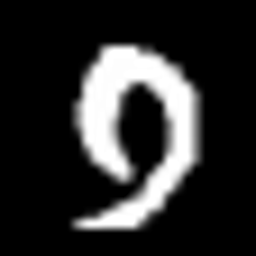

Label: 9
Prediction: 0


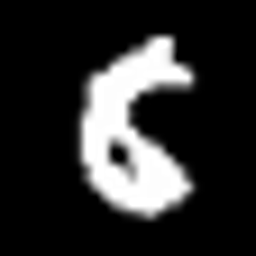

Label: 8
Prediction: 6


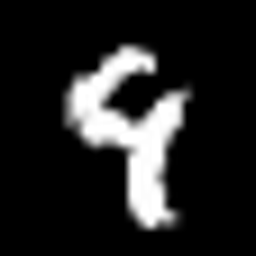

Label: 9
Prediction: 4


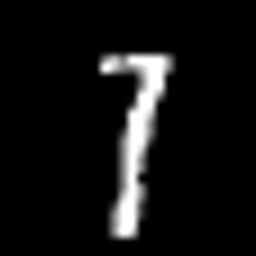

Label: 1
Prediction: 7


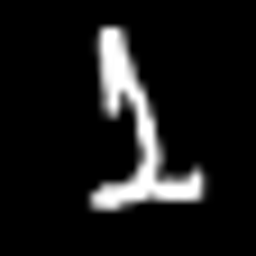

Label: 1
Prediction: 2


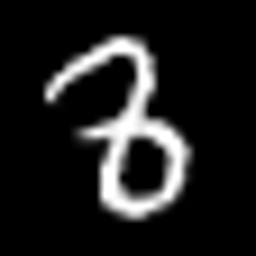

Label: 8
Prediction: 3


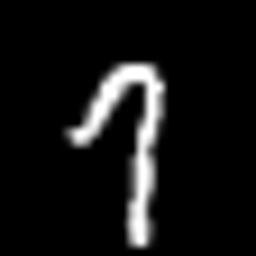

Label: 9
Prediction: 7


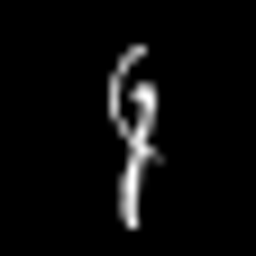

Label: 4
Prediction: 1


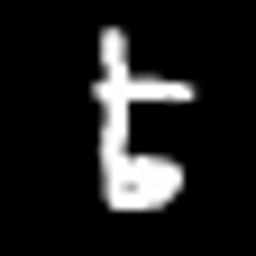

Label: 5
Prediction: 6


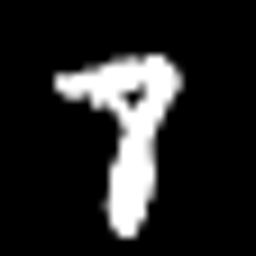

Label: 8
Prediction: 7


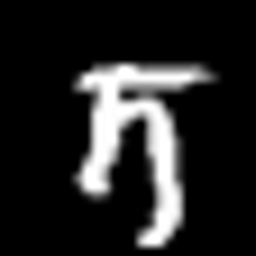

Label: 5
Prediction: 7


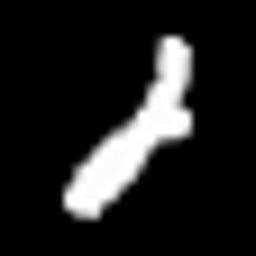

Label: 2
Prediction: 1


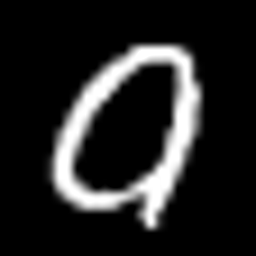

Label: 9
Prediction: 0


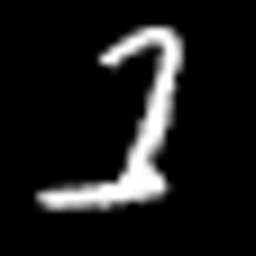

Label: 1
Prediction: 2


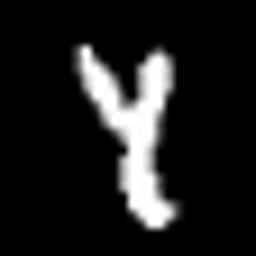

Label: 4
Prediction: 8


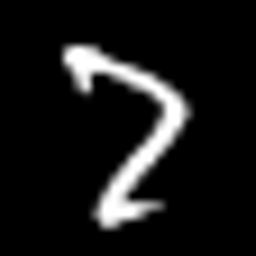

Label: 7
Prediction: 2


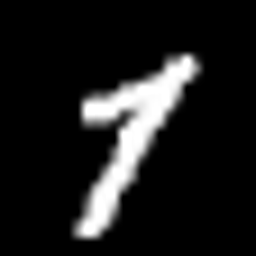

Label: 1
Prediction: 7


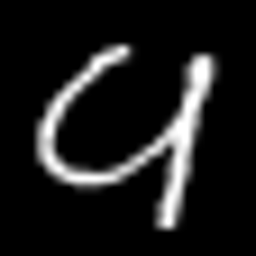

Label: 9
Prediction: 4


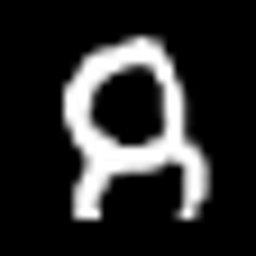

Label: 8
Prediction: 9


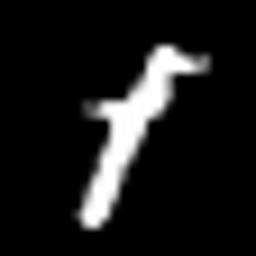

Label: 1
Prediction: 7


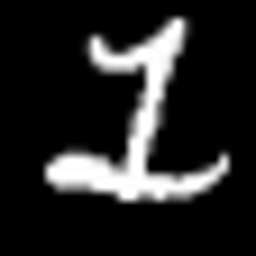

Label: 1
Prediction: 2


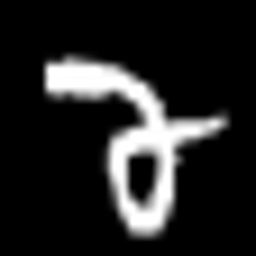

Label: 2
Prediction: 8


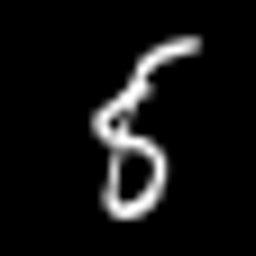

Label: 8
Prediction: 5


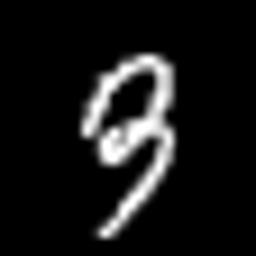

Label: 3
Prediction: 9


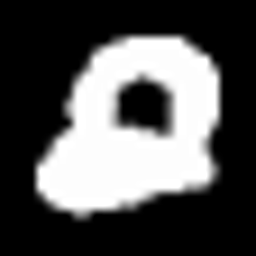

Label: 2
Prediction: 0


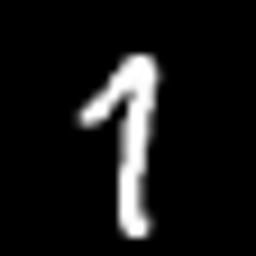

Label: 1
Prediction: 7


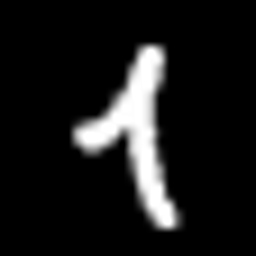

Label: 4
Prediction: 1


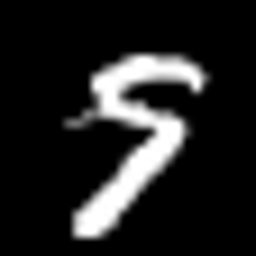

Label: 9
Prediction: 5


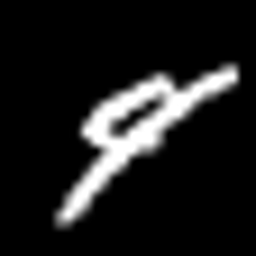

Label: 4
Prediction: 9


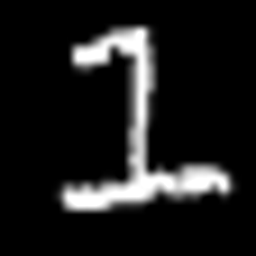

Label: 1
Prediction: 2


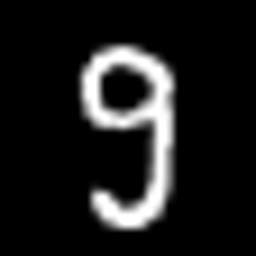

Label: 3
Prediction: 9


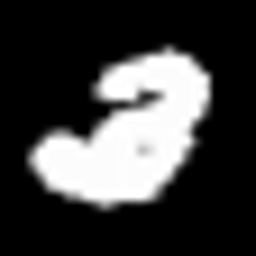

Label: 3
Prediction: 2


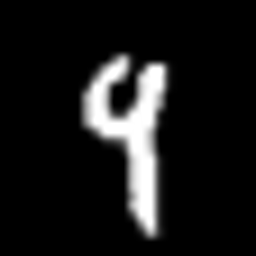

Label: 9
Prediction: 4


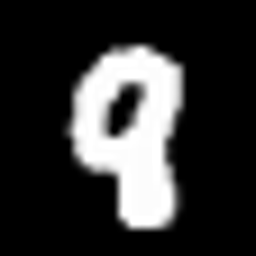

Label: 8
Prediction: 9


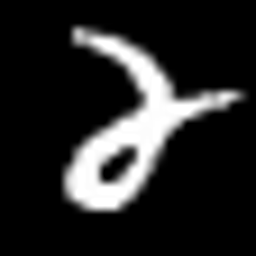

Label: 2
Prediction: 8


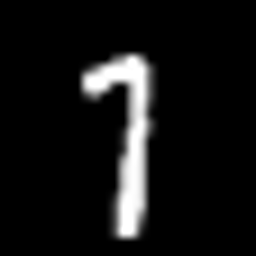

Label: 1
Prediction: 7


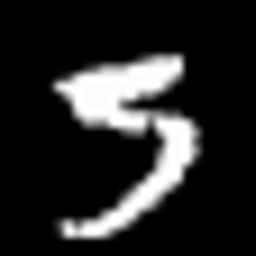

Label: 3
Prediction: 5


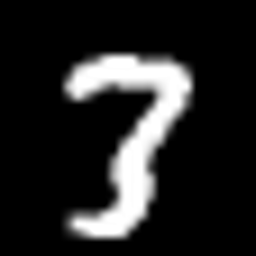

Label: 3
Prediction: 7


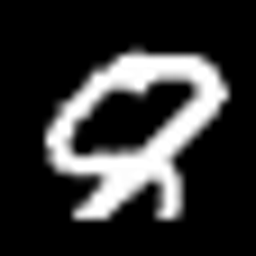

Label: 8
Prediction: 9


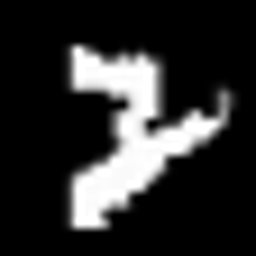

Label: 2
Prediction: 7


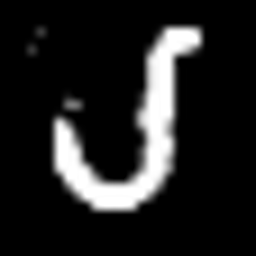

Label: 5
Prediction: 6


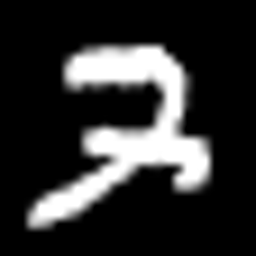

Label: 3
Prediction: 2


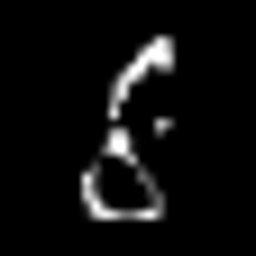

Label: 8
Prediction: 5


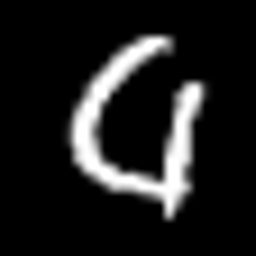

Label: 4
Prediction: 6


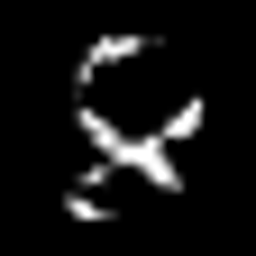

Label: 8
Prediction: 5


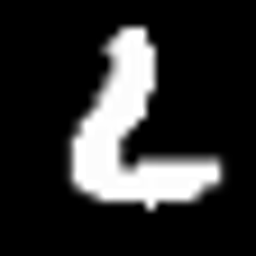

Label: 6
Prediction: 2


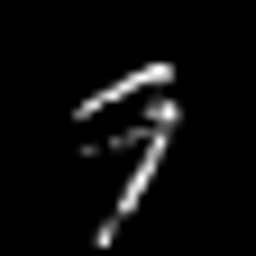

Label: 9
Prediction: 7


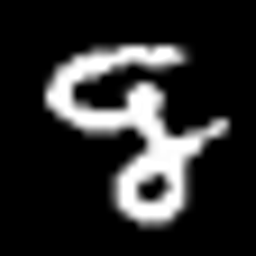

Label: 9
Prediction: 8


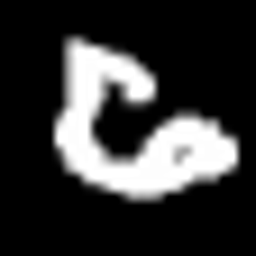

Label: 6
Prediction: 2


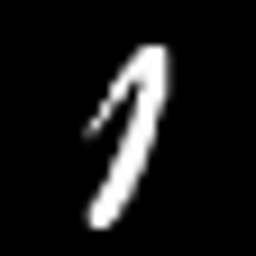

Label: 1
Prediction: 7


In [32]:
show_errors(df_val,indexes_to_check)

In [33]:
len(indexes_to_check)

58